In [24]:
#Canny Edge Detector
#Name: Anmol Bora
#Netid: arb790
#N No: N11599372

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import imageio as i
import math
import cv2

In [26]:
def GaussianSmoothing(image, kernel):
    output = np.zeros_like(image,dtype=float) #convolution output
    image_padded = np.zeros((image.shape[0]+6, image.shape[1]+6)) #Add zero padding to the input image
    image_padded[3:-3, 3:-3] = image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            #element-wise multiplication of the kernel and the image
            if (x>=3 and x<=image.shape[0]-4) and (y>=3 and y<=image.shape[1]-4):
                output[x,y]=np.sum(kernel*image_padded[x:x+7,y:y+7])/140
                #normalised by dividing by 140 which is the sum of the mask
            else:
                output[x,y]=0
                 #pixel values of first 4 rows 4 columns and last 4 rows 4 columns will be undefined
    return output

In [27]:
def GradientOperator(gaussian, op):
    ans = np.zeros_like(gaussian) #gx and gy output
    image_padded = np.zeros((gaussian.shape[0]+2, gaussian.shape[1]+2)) #Add zero padding to the input image
    image_padded[1:-1, 1:-1] = gaussian
    for x in range(gaussian.shape[0]):
        for y in range(gaussian.shape[1]):
            #element-wise multiplication of respective horizontal and vertical operator and the image
            if (x<=3 or x>=gaussian.shape[0]-4) or (y<=3 or y>=gaussian.shape[1]-4):
                ans[x,y]=0 
                #pixel values of first 4 rows 4 columns and last 4 rows 4 columns will be undefined
            else:
                ans[x,y]=(np.sum(op*image_padded[x:x+3,y:y+3]))/3 
                #normalised by dividing by 3
    return ans

In [28]:
def NMS(prewitt):
    max_sup = g.copy()
    for x in range(prewitt.shape[0]):
        for y in range(prewitt.shape[1]):
            if (x>=5 and x<=max_sup.shape[0]-6) and (y>=5 and y<=max_sup.shape[1]-6):
            #checking the edge angles
            #loop range is because of pixel values of first 5 rows 5 columns and last 5 rows 5 columns will be undefined
                if (prewitt[x][y]<22.5 and prewitt[x][y]>=0) or \
                    (prewitt[x][y]>=157.5 and prewitt[x][y]<202.5) or \
                    (prewitt[x][y]>=337.5 and prewitt[x][y]<=360):
                    prewitt[x][y]=0
                elif (prewitt[x][y]>=22.5 and prewitt[x][y]<67.5) or \
                    (prewitt[x][y]>=202.5 and prewitt[x][y]<247.5):
                    prewitt[x][y]=45
                elif (prewitt[x][y]>=67.5 and prewitt[x][y]<112.5)or \
                    (prewitt[x][y]>=247.5 and prewitt[x][y]<292.5):
                    prewitt[x][y]=90
                else:
                    prewitt[x][y]=135
            else:
                prewitt[x,y]=0

    for x in range(max_sup.shape[0]):
        for y in range(max_sup.shape[1]):
            if (x>=5 and x<=max_sup.shape[0]-6) and (y>=5 and y<=max_sup.shape[1]-6):
            #finally applyting non-maxima suppression
                if prewitt[x][y]==0:
                    if (g[x][y]<=g[x][y+1]) or \
                        (g[x][y]<=g[x][y-1]):
                        max_sup[x][y]=0
                elif prewitt[x][y]==45:
                    if (g[x][y]<=g[x-1][y+1]) or \
                        (g[x][y]<=g[x+1][y-1]):
                        max_sup[x][y]=0
                elif prewitt[x][y]==90:
                    if (g[x][y]<=g[x+1][y]) or \
                        (g[x][y]<=g[x-1][y]):
                        max_sup[x][y]=0
                else:
                    if (g[x][y]<=g[x+1][y+1]) or \
                        (g[x][y]<=g[x-1][y-1]):
                        max_sup[x][y]=0
            else:
                max_sup[x,y]=0
    return max_sup

In [29]:
def Thresholding(max_sup,th):
    histogram = [0]*256 
    final = np.zeros_like(max_sup)
    for x in range(max_sup.shape[0]):
        for y in range(max_sup.shape[1]):
            if int(max_sup[x][y])!=0:
                #each pixel from 0-255 with the respective intensities
                histogram[int(max_sup[x][y])]+=1
    
    ts=int(th*sum(histogram))

    j=255
    temp=ts
    while j>=0:
        #We start from the end as the foreground is dominating
        if temp-histogram[j]<=0:
            threshold = j
            break;
        else:
            temp=temp-histogram[j]
            j-=1

    for x in range(max_sup.shape[0]):
        for y in range(max_sup.shape[1]):
            #applying the P-tile thresholding method
            if max_sup[x][y]<threshold:
                final[x,y]=0
            else:
                final[x,y]=255
    count=0
    for x in range(max_sup.shape[0]):
        for y in range(max_sup.shape[1]):
            #calculating no. of edges detected
            if final[x][y]!=0:
                count+=1
    print ("Threshold for P= {}% is {}. Total Number of edges detected= {}".format(th*100,threshold,count))
    return final

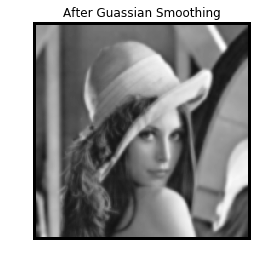

True

In [30]:
img = i.imread('Lena256.bmp')    #Load the image. Image and source code should be in same folder. Use ‘zebra.bmp’ for other image
kernel = np.array([[1,1,2,2,2,1,1],
                   [1,2,2,4,2,2,1],
                   [2,2,4,8,4,2,2],
                   [2,4,8,16,8,4,2],
                   [2,2,4,8,4,2,2],
                   [1,2,2,4,2,2,1],
                   [1,1,2,2,2,1,1]]) #gaussian mask

px = np.array([[-1, 0, 1], 
               [-1, 0, 1], 
               [-1, 0, 1]]) #horizontal operator
py = np.array([[1, 1, 1], 
               [0, 0, 0], 
               [-1, -1, -1]]) #vertical operator

gaussian = GaussianSmoothing(img,kernel) #result after Gaussian Smoothing
plt.imshow(gaussian, cmap=plt.cm.gray)
plt.title("After Guassian Smoothing")
plt.axis('off')
plt.show()
cv2.imwrite('STEP1-AfterGuassianSmoothing.jpg',gaussian)

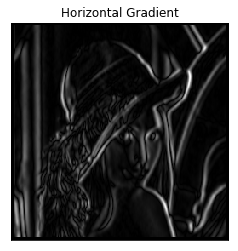

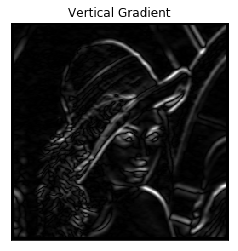

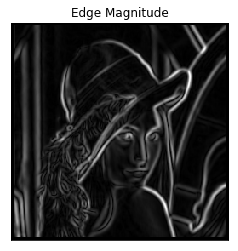

True

In [31]:
prewitt = np.zeros_like(gaussian)
gx = np.zeros_like(gaussian)
gy = np.zeros_like(gaussian)
gx = GradientOperator(gaussian, px) #horizontal gradient
gx1=abs(gx) #we take absolute values for display purpose
gy = GradientOperator(gaussian, py) #vertical gradient
gy1=abs(gy)
g = (np.sqrt((gx1 * gx1) + (gy1 * gy1))/math.sqrt(2)) #normalise the magnitude by root(2)
prewitt = (np.arctan2(gy, gx) * (180/np.pi)) #calculate the edge angles
plt.imshow(gx1, cmap=plt.cm.gray)
plt.title("Horizontal Gradient")
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('STEP2-GX.jpg', gx1)

plt.imshow(gy1, cmap=plt.cm.gray)
plt.title("Vertical Gradient")
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('STEP2-GY.jpg',gy1)

plt.imshow(g, cmap=plt.cm.gray)
plt.title("Edge Magnitude")
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('STEP3-G.jpg',g)

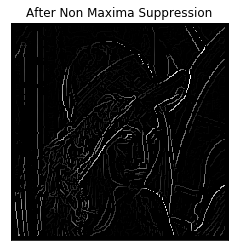

True

In [32]:
max_sup = NMS(prewitt)
plt.imshow(max_sup, cmap=plt.cm.gray)
plt.title('After Non Maxima Suppression')
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('STEP4-AfterNMS.jpg', max_sup)
#np.savetxt("check.csv", max_sup, delimiter=",")

Threshold for P= 10.0% is 30. Total Number of edges detected= 1169


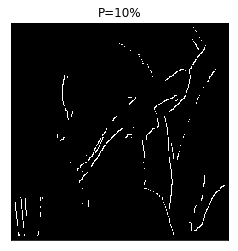

Threshold for P= 30.0% is 14. Total Number of edges detected= 3539


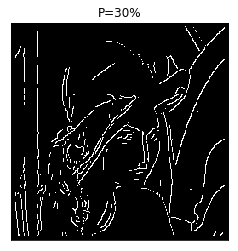

Threshold for P= 50.0% is 6. Total Number of edges detected= 5870


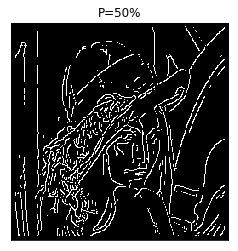

True

In [33]:
first = max_sup.copy()
second = max_sup.copy()
third = max_sup.copy()
t1=0.1
t2=0.3
t3=0.5

first = Thresholding(max_sup,t1) #result for P=10%
plt.imshow(first, cmap=plt.cm.gray)
plt.title('P=10%')
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('STEP5-10percent.jpg', first)

second = Thresholding(max_sup,t2) #result for P=30%
plt.imshow(second, cmap=plt.cm.gray)
plt.title('P=30%')
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('STEP5-30percent.jpg', second)

third = Thresholding(max_sup,t3) #result for P=50%
plt.imshow(third, cmap=plt.cm.gray)
plt.title('P=50%')
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('STEP5-50percent.jpg', third)